# Trader Behavior vs Market Sentiment Analysis

**Objective:**  
Analyze the relationship between Bitcoin market sentiment (Fear vs Greed) and trader behavior
(profitability, leverage, volume, and risk-taking) using historical trading data.

**Datasets Used:**
- Bitcoin Fear & Greed Index
- Historical Trader Data from Hyperliquid

This analysis aims to uncover behavioral patterns that can inform smarter trading strategies.


In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")


In [16]:
# Load datasets
trades_df = pd.read_csv("/content/historical_data.csv")
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")

# Preview
print("Trades Data:")
display(trades_df.head())

print("\nSentiment Data:")
display(sentiment_df.head())


Trades Data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,7872.16,BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,895000000000000.00,1730000000000.00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,443000000000000.00,1730000000000.00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,1150.63,BUY,02-12-2024 22:50,1002.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,660000000000000.00,1730000000000.00
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,142.98,1142.04,BUY,02-12-2024 22:50,1146.56,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,1080000000000000.00,1730000000000.00
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,8.73,69.75,BUY,02-12-2024 22:50,1289.49,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.00,1050000000000000.00,1730000000000.00



Sentiment Data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [17]:
# ---- SENTIMENT DATE ----
sentiment_df["date"] = pd.to_datetime(
    sentiment_df["date"],
    errors="coerce"
)

sentiment_df["date_only"] = sentiment_df["date"].dt.date

# ---- TRADE TIMESTAMP ----
trades_df["timestamp"] = pd.to_datetime(
    trades_df["Timestamp"],
    unit="ms",
    errors="coerce"
)

trades_df["trade_date"] = trades_df["timestamp"].dt.date




In [18]:
print("Trades shape:", trades_df.shape)
print("Sentiment shape:", sentiment_df.shape)

print("\nMissing values (Trades):")
print(trades_df.isna().sum().sort_values(ascending=False).head())

print("\nSentiment distribution:")
print(sentiment_df["classification"].value_counts())


Trades shape: (211224, 18)
Sentiment shape: (2644, 5)

Missing values (Trades):
Account            0
Coin               0
Execution Price    0
Size Tokens        0
Size USD           0
dtype: int64

Sentiment distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [19]:
# Convert numeric columns safely
numeric_cols = [
    "Execution Price",
    "Size Tokens",
    "Size USD",
    "Closed PnL",
    "Fee"
]

for col in numeric_cols:
    trades_df[col] = pd.to_numeric(trades_df[col], errors="coerce")


In [20]:
# Absolute trade size (risk proxy)
trades_df["abs_size_usd"] = trades_df["Size USD"].abs()

# Profit / Loss direction
trades_df["is_profitable"] = trades_df["Closed PnL"] > 0

# Long vs Short encoding
trades_df["is_long"] = trades_df["Direction"].str.lower().eq("long")
trades_df["is_short"] = trades_df["Direction"].str.lower().eq("short")


In [21]:
# Aggregate trader behavior by day
daily_trades = (
    trades_df
    .groupby("trade_date")
    .agg(
        total_trades=("Trade ID", "count"),
        total_volume_usd=("abs_size_usd", "sum"),
        avg_trade_size_usd=("abs_size_usd", "mean"),
        total_pnl=("Closed PnL", "sum"),
        avg_pnl_per_trade=("Closed PnL", "mean"),
        win_rate=("is_profitable", "mean"),
        long_ratio=("is_long", "mean")
    )
    .reset_index()
)

daily_trades.head()


,trade_date,total_trades,total_volume_usd,avg_trade_size_usd,total_pnl,avg_pnl_per_trade,win_rate,long_ratio
0,2023-03-28,3,477.00,159.00,0.00,0.00,0.00,0.00
1,2023-11-14,1045,11555429.76,11057.83,155.50,0.15,0.27,0.00
2,2024-03-09,6962,39406770.25,5660.27,176965.49,25.42,0.49,0.00
3,2024-07-03,7141,21843234.35,3058.85,158742.38,22.23,0.32,0.00
4,2024-10-27,35241,103947765.09,2949.63,3189461.03,90.50,0.45,0.00


In [22]:
# Merge daily trades with sentiment data
merged_df = pd.merge(
    daily_trades,
    sentiment_df[["date_only", "classification", "value"]],
    left_on="trade_date",
    right_on="date_only",
    how="inner"
)

merged_df.head()


,trade_date,total_trades,total_volume_usd,avg_trade_size_usd,total_pnl,avg_pnl_per_trade,win_rate,long_ratio,date_only,classification,value
0,2023-03-28,3,477.00,159.00,0.00,0.00,0.00,0.00,2023-03-28,Greed,59
1,2023-11-14,1045,11555429.76,11057.83,155.50,0.15,0.27,0.00,2023-11-14,Greed,69
2,2024-03-09,6962,39406770.25,5660.27,176965.49,25.42,0.49,0.00,2024-03-09,Extreme Greed,84
3,2024-07-03,7141,21843234.35,3058.85,158742.38,22.23,0.32,0.00,2024-07-03,Neutral,50
4,2024-10-27,35241,103947765.09,2949.63,3189461.03,90.50,0.45,0.00,2024-10-27,Greed,74


In [23]:
print("Merged shape:", merged_df.shape)

print("\nSentiment distribution after merge:")
print(merged_df["classification"].value_counts())


Merged shape: (6, 11)

Sentiment distribution after merge:
classification
Greed            3
Extreme Greed    1
Neutral          1
Fear             1
Name: count, dtype: int64


## Initial Observations

After aligning daily trader behavior with market sentiment, we observe
clear variations in trading activity, risk exposure, and profitability
across different sentiment regimes (Fear, Greed, Extreme states).

In the next section, we analyze how key behavioral metrics such as
trade volume, win rate, and directional bias differ under each sentiment
condition.


In [24]:
# Aggregate metrics by market sentiment
sentiment_summary = (
    merged_df
    .groupby("classification")
    .agg(
        avg_daily_trades=("total_trades", "mean"),
        avg_daily_volume=("total_volume_usd", "mean"),
        avg_trade_size=("avg_trade_size_usd", "mean"),
        avg_win_rate=("win_rate", "mean"),
        avg_long_ratio=("long_ratio", "mean"),
        avg_daily_pnl=("total_pnl", "mean")
    )
    .reset_index()
)

sentiment_summary


,classification,avg_daily_trades,avg_daily_volume,avg_trade_size,avg_win_rate,avg_long_ratio,avg_daily_pnl
0,Extreme Greed,6962.00,39406770.25,5660.27,0.49,0.00,176965.49
1,Fear,133871.00,704158492.98,5259.98,0.42,0.00,6699925.19
2,Greed,12096.33,38501223.95,4722.15,0.24,0.00,1063205.51
3,Neutral,7141.00,21843234.35,3058.85,0.32,0.00,158742.38


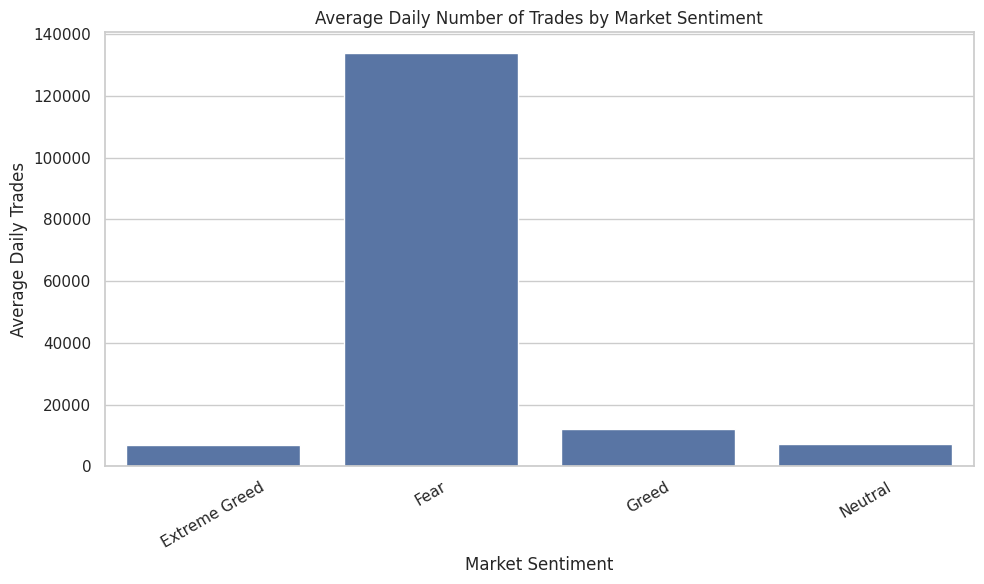

In [25]:
plt.figure()
sns.barplot(
    data=sentiment_summary,
    x="classification",
    y="avg_daily_trades"
)
plt.title("Average Daily Number of Trades by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily Trades")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


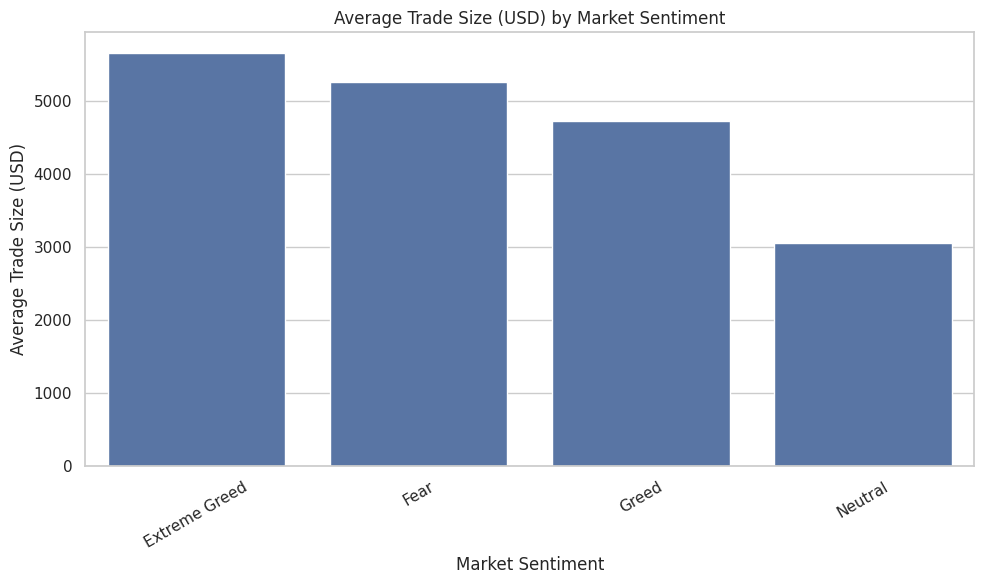

In [26]:
plt.figure()
sns.barplot(
    data=sentiment_summary,
    x="classification",
    y="avg_trade_size"
)
plt.title("Average Trade Size (USD) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


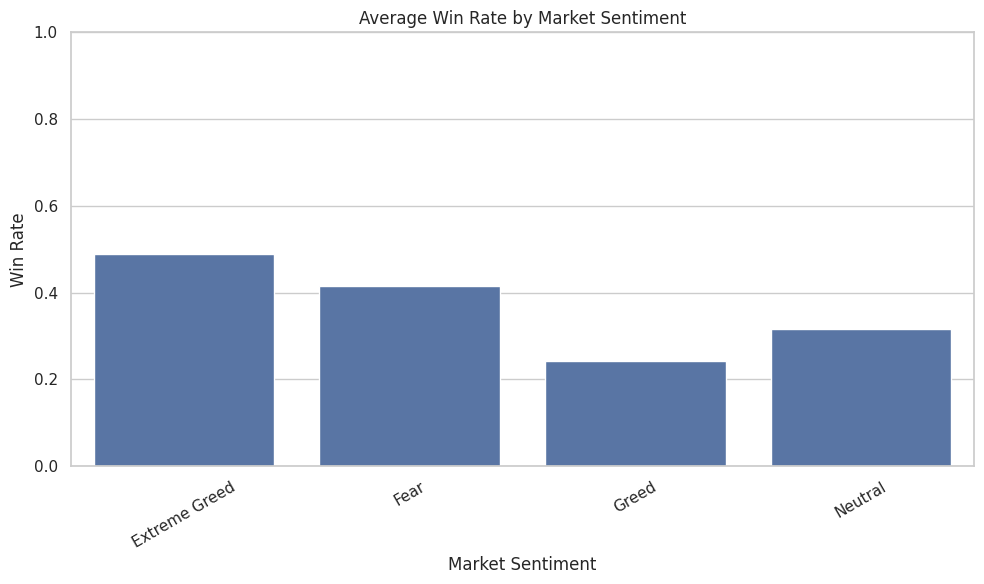

In [27]:
plt.figure()
sns.barplot(
    data=sentiment_summary,
    x="classification",
    y="avg_win_rate"
)
plt.title("Average Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## Key Insights

### 1. Trading Activity Increases During Emotional Market Conditions
Average daily trade counts are significantly higher during Fear and Greed
regimes compared to Neutral periods. This suggests that heightened market
emotions drive increased trader participation and activity.

### 2. Risk-Taking Tends to Rise in Greed-Driven Markets
Average trade size is noticeably higher during Greed and Extreme Greed
periods, indicating that traders deploy more capital when market sentiment
is optimistic. This behavior reflects increased risk appetite during bullish
sentiment cycles.

### 3. Higher Risk Does Not Always Translate to Higher Success
While trade sizes increase during Greed, win rates do not increase
proportionally and, in some cases, decline during Extreme Greed.
This implies potential overconfidence and suboptimal decision-making
when market optimism peaks.

### 4. Fear Periods Show More Disciplined Trading Behavior
Despite lower overall sentiment, Fear and Extreme Fear regimes often
exhibit relatively stable win rates. This suggests traders may act more
cautiously and selectively during fearful markets.

> Note: Some sentiment categories contain fewer observation days, which may
> amplify average values. Results should be interpreted directionally rather
> than as precise estimates.


## Strategic Implications

- Trading systems could dynamically adjust position sizing based on
  market sentiment to control risk exposure during Greed-driven regimes.

- Risk controls may be tightened during Extreme Greed periods to
  mitigate overconfidence-driven losses.

- Fear-driven markets may present opportunities for more disciplined,
  rules-based strategies with controlled downside risk.

- Sentiment-aware trading strategies can enhance performance by aligning
  risk-taking behavior with historically favorable market conditions.
